# Week 2: Day 3 PM // Naive Bayes

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 2.9MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-cp37-none-any.whl size=73053 sha256=ba10c5ca0be95530e9e844bc8e699c25be7f2d5d1ae0d111938c5d5a7efdb8bd
  Stored in directory: /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303
Successfully built kaggle
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"muhammadadinugroho","key":"dddaf77eec9cc37ebef28bf7d8531c86"}'}

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              224KB  2021-04-24 17:07:26           3685        362  1.0              
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-02-17 16:10:44           2126        215  1.0              
promptcloud/careerbuilder-job-listing-2020                  Careerbuilder Job Listing 2020                     42MB  2021-03-05 06:59:52            446         20  1.0              
dhruvildave/wikibooks-dataset                               Wikibooks Dataset             

In [ ]:
!kaggle competitions list -s titanic

ref      deadline             category            reward  teamCount  userHasEntered  
-------  -------------------  ---------------  ---------  ---------  --------------  
titanic  2030-01-01 00:00:00  Getting Started  Knowledge      34300           False  


In [ ]:
!mkdir titanic

In [ ]:
!kaggle competitions download -c "titanic"

  0% 0.00/34.1k [00:00<?, ?B/s]
100% 34.1k/34.1k [00:00<00:00, 22.4MB/s]


In [ ]:
!unzip titanic.zip -d titanic

Archive:  titanic.zip
  inflating: titanic/gender_submission.csv  
  inflating: titanic/test.csv        
  inflating: titanic/train.csv       


Naive Bayes employ bayesian logic and theorem to infer probability given hypotheses and their evidences.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc,roc_auc_score
import time
import pandas as pd

%matplotlib inline

To solidify our understanding of Bayes Theorem and Naive Bayes,we will manually implement Bayes Theorem by Pandas and compare it with Sk-Learn utility.

We will intialize a toy dataset containing whether a family buy a car given their family structure, age group, and income.

In [ ]:
# Assigning features and label variables
family_struct = ['Nuclear','Extended','Childless','Childless','Single Parent','Childless','Nuclear','Nuclear','Extended','Single Parent']
age_group = ['Young','Old','Middle-aged','Young','Middle-aged','Young','Old','Middle-aged','Middle-aged','Old']
income = ['Low','Low','Low','Medium','Medium','Low','High','Medium','High','Low']
buy_car = ['Yes','No','No','Yes','Yes','No','Yes','Yes','Yes','No']

In [ ]:
dict = {'family_struct': family_struct,'age_group':age_group,'income':income,'buy_car':buy_car} 
    
df = pd.DataFrame(dict)
df.columns=list(df.columns[:-1])+['label'] 

In [ ]:
df

,family_struct,age_group,income,label
0,Nuclear,Young,Low,Yes
1,Extended,Old,Low,No
2,Childless,Middle-aged,Low,No
3,Childless,Young,Medium,Yes
4,Single Parent,Middle-aged,Medium,Yes
5,Childless,Young,Low,No
6,Nuclear,Old,High,Yes
7,Nuclear,Middle-aged,Medium,Yes
8,Extended,Middle-aged,High,Yes
9,Single Parent,Old,Low,No


Firstly, we count the probability of our class/label

In [ ]:
df_grp_lbl=df.groupby('label').count().reset_index()[['label','income']]
df_grp_lbl.columns=list(df_grp_lbl.columns[:-1])+['f_h']
df_grp_lbl['p_h']=df_grp_lbl['f_h']/df_grp_lbl['f_h'].sum()

In [ ]:
df_grp_lbl

,label,f_h,p_h
0,No,4,0.4
1,Yes,6,0.6


Next, we count the frequency of each events. We will need this to count the conditional probability.

In [ ]:
df_melt = df.melt(id_vars=['label'],var_name='features',value_name='value')
df_melt.columns=['label']+list(df_melt.columns[1:])

In [ ]:
df_grp=df_melt.groupby(['label','features','value']).size().reset_index(name='count')
df_grp.columns=list(df_grp.columns[:-1])+['f_e_given_h']
df_grp[df_grp['value']=='Low'].head(5)

,label,features,value,f_e_given_h
6,No,income,Low,4
15,Yes,income,Low,1


In [ ]:
df_a=df_grp.groupby((['features','value'])).count().reset_index()[['features','value']]
df_a['key']=1
df_b = df_grp_lbl
df_b['key']=1
df_feat=pd.merge(df_a, df_b, on ='key').drop("key", 1)

Then, we built the conditional probability table. In case there is a combination of event and hypotheses that never happened, i.e. Nuclei family size not buying car, we will fill the conditional probability with the prior probability of given class.

In [ ]:
df_prob=df_feat.merge(df_grp,on=['label','features','value'],how='outer')
df_prob['p_e_given_h']=df_prob['f_e_given_h']/df_prob['f_h']
df_prob['p_e_given_h']=df_prob['p_e_given_h'].fillna(0)

In [ ]:
df_prob

,features,value,label,f_h,p_h,f_e_given_h,p_e_given_h
0,age_group,Middle-aged,No,4,0.4,1.0,0.250000
1,age_group,Middle-aged,Yes,6,0.6,3.0,0.500000
2,age_group,Old,No,4,0.4,2.0,0.500000
3,age_group,Old,Yes,6,0.6,1.0,0.166667
4,age_group,Young,No,4,0.4,1.0,0.250000
5,age_group,Young,Yes,6,0.6,2.0,0.333333
6,family_struct,Childless,No,4,0.4,2.0,0.500000
7,family_struct,Childless,Yes,6,0.6,1.0,0.166667
8,family_struct,Extended,No,4,0.4,1.0,0.250000
9,family_struct,Extended,Yes,6,0.6,1.0,0.166667


We can then use this table as a lookup to infer our data. As example, lets try to infer a family which is Single Parent, Young, with Low income.

In [ ]:
df_ext=df_prob[(df_prob['value'].isin(['Single Parent','Young','Low']))]
df_ext=df_ext.groupby('label').agg({'p_e_given_h':np.prod}).reset_index()
df_ext.columns=['label','p_h']
df_ext['total_prob']=df_ext['p_h'].sum()
df_ext['norm_prob']=df_ext['p_h']/df_ext['total_prob']

In [ ]:
df_ext

,label,p_h,total_prob,norm_prob
0,No,0.062500,0.071759,0.870968
1,Yes,0.009259,0.071759,0.129032


Let's inference all our training data

In [ ]:
small_dfs = []
X=df[df.columns[:-1]]
for idx in range(len(X)):
    df_select = X.iloc[[idx]]
    df_ext=df_prob[df_prob['value'].isin(df_select.values[0])]
    df_ext=df_ext.groupby('label').agg({'p_e_given_h':np.prod}).reset_index()
    df_ext.columns=['label','p_h']
    df_ext['total_prob']=df_ext['p_h'].sum()
    df_ext['norm_prob']=df_ext['p_h']/df_ext['total_prob']
    df_select['prob_no']=df_ext[df_ext['label']=='No']['norm_prob'].values[0]
    df_select['prob_yes']=df_ext[df_ext['label']=='Yes']['norm_prob'].values[0]
    small_dfs.append(df_select)
    
df_infer = pd.concat(small_dfs, ignore_index=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
df_infer

,family_struct,age_group,income,prob_no,prob_yes
0,Nuclear,Young,Low,0.000000,1.000000
1,Extended,Old,Low,0.964286,0.035714
2,Childless,Middle-aged,Low,0.900000,0.100000
3,Childless,Young,Medium,0.000000,1.000000
4,Single Parent,Middle-aged,Medium,0.000000,1.000000
5,Childless,Young,Low,0.931034,0.068966
6,Nuclear,Old,High,0.000000,1.000000
7,Nuclear,Middle-aged,Medium,0.000000,1.000000
8,Extended,Middle-aged,High,0.000000,1.000000
9,Single Parent,Old,Low,0.964286,0.035714


Let's compare it with Sk-Learn implementation

In [ ]:
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
enc = OneHotEncoder()

X = df[df.columns[:-1]]
enc.fit(X)

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='error', sparse=True)

In [ ]:
X_enc=enc.transform(X).toarray()

le = LabelEncoder()
label_encoded=le.fit_transform(df['label'])
print("Label:",label_encoded)

Label: [1 0 0 1 1 0 1 1 1 0]


In [ ]:
# Import Gaussian Naive Bayes model
from sklearn.naive_bayes import BernoulliNB

# Create a Gaussian Classifier
model = BernoulliNB()

# Train the model using the training sets
model.fit(X_enc,label_encoded)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [ ]:
df_result_sklearn = df_infer.copy()
df_result_sklearn['prob_no_sklearn'] =  model.predict_proba(X_enc)[:,0]
df_result_sklearn['prob_yes_sklearn'] =  model.predict_proba(X_enc)[:,1]
df_result_sklearn 

,family_struct,age_group,income,prob_no,prob_yes,prob_no_sklearn,prob_yes_sklearn
0,Nuclear,Young,Low,0.000000,1.000000,0.406563,0.593437
1,Extended,Old,Low,0.964286,0.035714,0.948712,0.051288
2,Childless,Middle-aged,Low,0.900000,0.100000,0.860450,0.139550
3,Childless,Young,Medium,0.000000,1.000000,0.120508,0.879492
4,Single Parent,Middle-aged,Medium,0.000000,1.000000,0.039483,0.960517
5,Childless,Young,Low,0.931034,0.068966,0.911320,0.088680
6,Nuclear,Old,High,0.000000,1.000000,0.051960,0.948040
7,Nuclear,Middle-aged,Medium,0.000000,1.000000,0.005451,0.994549
8,Extended,Middle-aged,High,0.000000,1.000000,0.064117,0.935883
9,Single Parent,Old,Low,0.964286,0.035714,0.948712,0.051288


Now we have seen how Naive Bayes work on categorical data. Let's see how Bayes Classifier works on numerical data, specifically we will see its decision boundary. We will use toy datasets with various shapes

In [ ]:
mean1 = (2, 3);cov1 = [[1, 0], [0, 1]]
data_1 = np.random.multivariate_normal(mean1, cov1, (1000))

mean2 = (0, 0);cov2 = [[1, 0], [0, 1]]
data_2 = np.random.multivariate_normal(mean2, cov2, (1000))

X_1 = np.vstack([data_1,data_2])
y_1  = np.hstack([[1]*len(data_1),[2]*len(data_2)])
#X,y=make_circles(n_samples=500,noise=0.2, factor=0.4, random_state=1)
#plt.scatter(X[:,0],X[:,1],c=y)

X_2,y_2=make_circles(n_samples=500,noise=0.2, factor=0.4, random_state=1)

datas = [[X_1,y_1],[X_2,y_2]]

Plot dataset

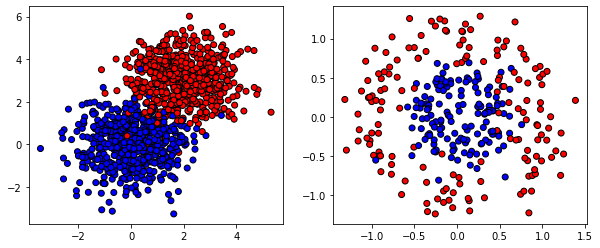

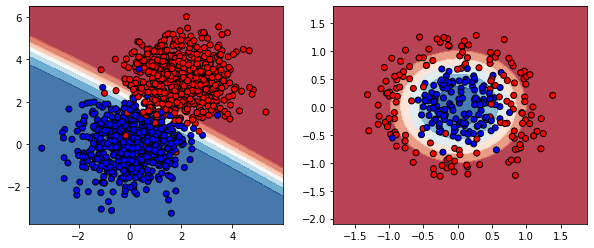

In [ ]:
fig,axs = plt.subplots(1,2,figsize=(10,4))
fig,axs2 = plt.subplots(1,2,figsize=(10,4))
for idx,ax in enumerate(axs):
  X = datas[idx][0]
  y = datas[idx][1]
  h = .02  # step size in the mesh

  X_train, X_test, y_train, y_test = \
      train_test_split(X, y, test_size=.4, random_state=42)
  # just plot the dataset first
  cm = plt.cm.RdBu 
  cm_bright = ListedColormap(['#FF0000', '#0000FF'])
  # Plot the training points
  ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
            edgecolors='k')
  

  x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
  y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                      np.arange(y_min, y_max, h))

  gnb = GaussianNB()
  model_gnb = gnb.fit(X, y)
  Z = gnb.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
  Z = Z.reshape(xx.shape)
  axs2[idx].contourf(xx, yy, Z, cmap=cm, alpha=.8)
  axs2[idx].scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                edgecolors='k')
plt.show()

We see Bayes Classifier able to build a elliptical decision boundary.

### Test on Kaggle Dataset

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 2.9MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-cp37-none-any.whl size=73053 sha256=ba10c5ca0be95530e9e844bc8e699c25be7f2d5d1ae0d111938c5d5a7efdb8bd
  Stored in directory: /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303
Successfully built kaggle
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"muhammadadinugroho","key":"dddaf77eec9cc37ebef28bf7d8531c86"}'}

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              224KB  2021-04-24 17:07:26           3685        362  1.0              
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-02-17 16:10:44           2126        215  1.0              
promptcloud/careerbuilder-job-listing-2020                  Careerbuilder Job Listing 2020                     42MB  2021-03-05 06:59:52            446         20  1.0              
dhruvildave/wikibooks-dataset                               Wikibooks Dataset             

In [ ]:
!kaggle competitions list -s titanic

ref      deadline             category            reward  teamCount  userHasEntered  
-------  -------------------  ---------------  ---------  ---------  --------------  
titanic  2030-01-01 00:00:00  Getting Started  Knowledge      34300           False  


In [ ]:
!mkdir titanic

In [ ]:
!kaggle competitions download -c "titanic"

  0% 0.00/34.1k [00:00<?, ?B/s]
100% 34.1k/34.1k [00:00<00:00, 22.4MB/s]


In [ ]:
!unzip titanic.zip -d titanic

Archive:  titanic.zip
  inflating: titanic/gender_submission.csv  
  inflating: titanic/test.csv        
  inflating: titanic/train.csv       


In [ ]:
df_titanic=pd.read_csv('titanic/train.csv', error_bad_lines = False)
#df_titanic.columns = df_book.columns.str.strip()

In [ ]:
print(df_titanic.shape)
df_titanic.head(5)

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
df_titanic.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [ ]:
column_x=['Pclass','Sex','SibSp','Parch','Ticket','Fare','Embarked']
df_train=df_titanic[~df_titanic['Embarked'].isna()]
X=df_train[column_x]

In [ ]:
df_train.shape

(889, 12)